The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.13.2 -f https://d2l.ai/whl.html # installing d2l


# Densely Connected Networks (DenseNet)

ResNet significantly changed the view of how to parametrize the functions in deep networks. DenseNet is to some extent the logical extension of this. To understand how to arrive at it, let us take a small detour to theory. Recall the Taylor expansion for functions. For scalars it can be written as

$$f(x) = f(0) + f'(x) x + \frac{1}{2} f''(x) x^2 + \frac{1}{6} f'''(x) x^3 + o(x^3).$$

## Function Decomposition

The key point is that it decomposes the function into increasingly higher order terms. In a similar vein, ResNet decomposes functions into

$$f(\mathbf{x}) = \mathbf{x} + g(\mathbf{x}).$$

That is, ResNet decomposes $f$ into a simple linear term and a more complex
nonlinear one. What if we want to go beyond two terms? A solution was proposed
by :cite:`Huang.Liu.Van-Der-Maaten.ea.2017` in the form of
DenseNet, an architecture that reported record performance on the ImageNet
dataset.

![The main difference between ResNet (left) and DenseNet (right) in cross-layer connections: use of addition and use of concatenation. ](../img/densenet-block.svg)
:label:`fig_densenet_block`

As shown in :numref:`fig_densenet_block`, the key difference between ResNet and DenseNet is that in the latter case outputs are *concatenated* rather than added. As a result we perform a mapping from $\mathbf{x}$ to its values after applying an increasingly complex sequence of functions.

$$\mathbf{x} \to \left[\mathbf{x}, f_1(\mathbf{x}), f_2(\mathbf{x}, f_1(\mathbf{x})), f_3(\mathbf{x}, f_1(\mathbf{x}), f_2(\mathbf{x}, f_1(\mathbf{x})), \ldots\right].$$

In the end, all these functions are combined in an MLP to reduce the number of features again. In terms of implementation this is quite simple---rather than adding terms, we concatenate them. The name DenseNet arises from the fact that the dependency graph between variables becomes quite dense. The last layer of such a chain is densely connected to all previous layers. The main components that compose a DenseNet are dense blocks and transition layers. The former defines how the inputs and outputs are concatenated, while the latter controls the number of channels so that it is not too large. The dense connections are shown in :numref:`fig_densenet`.

![Dense connections in DenseNet](http://d2l.ai/_images/densenet.svg)
:label:`fig_densenet`


## Dense Blocks

DenseNet uses the modified "batch normalization, activation, and convolution"
architecture of ResNet (see the exercise in :numref:`sec_resnet`).
First, we implement this architecture in the
`conv_block` function.

In [1]:
from d2l import torch as d2l
import torch
from torch import nn

def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

A dense block consists of multiple `conv_block` units, each using the same number of output channels. In the forward computation, however, we concatenate the input and output of each block on the channel dimension.

In [2]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels*i+input_channels, num_channels))
        self.net = nn.Sequential(*layer)
    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate the input and output of each block on the channel
            # dimension
            X = torch.cat((X, Y), dim=1)
        return X

In the following example, we define a convolution block (`DenseBlock`) with two blocks of 10 output channels. When using an input with 3 channels, we will get an output with the $3+2\times 10=23$ channels. The number of convolution block channels controls the increase in the number of output channels relative to the number of input channels. This is also referred to as the growth rate.

In [3]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

## Transition Layers

Since each dense block will increase the number of channels, adding too many of them will lead to an excessively complex model. A transition layer is used to control the complexity of the model. It reduces the number of channels by using the $1\times 1$ convolutional layer and halves the height and width of the average pooling layer with a stride of 2, further reducing the complexity of the model.

In [4]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

Apply a transition layer with 10 channels to the output of the dense block in the previous example.  This reduces the number of output channels to 10, and halves the height and width.

In [5]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

## DenseNet Model

Next, we will construct a DenseNet model. DenseNet first uses the same single convolutional layer and maximum pooling layer as ResNet.

In [6]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

Then, similar to the four residual blocks that ResNet uses, DenseNet uses four dense blocks. Similar to ResNet, we can set the number of convolutional layers used in each dense block. Here, we set it to 4, consistent with the ResNet-18 in the previous section. Furthermore, we set the number of channels (i.e., growth rate) for the convolutional layers in the dense block to 32, so 128 channels will be added to each dense block.

In ResNet, the height and width are reduced between each module by a residual block with a stride of 2. Here, we use the transition layer to halve the height and width and halve the number of channels.

In [7]:
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # This is the number of output channels in the previous dense block
    num_channels += num_convs * growth_rate
    # A transition layer that haves the number of channels is added between
    # the dense blocks
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

Similar to ResNet, a global pooling layer and fully connected layer are connected at the end to produce the output.

In [8]:
net = nn.Sequential(
    b1, *blks, 
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveMaxPool2d((1,1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10))

## Data Acquisition and Training

Since we are using a deeper network here, in this section, we will reduce the input height and width from 224 to 96 to simplify the computation.

loss 0.149, train acc 0.946, test acc 0.906
5358.5 examples/sec on cuda:0


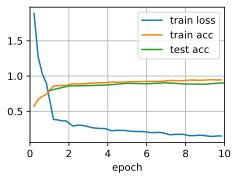

In [9]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

## Summary

* In terms of cross-layer connections, unlike ResNet, where inputs and outputs are added together, DenseNet concatenates inputs and outputs on the channel dimension.
* The main units that compose DenseNet are dense blocks and transition layers.
* We need to keep the dimensionality under control when composing the network by adding transition layers that shrink the number of channels again.

## Exercises

1. Why do we use average pooling rather than max-pooling in the transition layer?
1. One of the advantages mentioned in the DenseNet paper is that its model parameters are smaller than those of ResNet. Why is this the case?
1. One problem for which DenseNet has been criticized is its high memory consumption.
    * Is this really the case? Try to change the input shape to $224\times 224$ to see the actual (GPU) memory consumption.
    * Can you think of an alternative means of reducing the memory consumption? How would you need to change the framework?
1. Implement the various DenseNet versions presented in Table 1 of :cite:`Huang.Liu.Van-Der-Maaten.ea.2017`.
1. Why do we not need to concatenate terms if we are just interested in $\mathbf{x}$ and $f(\mathbf{x})$ for ResNet? Why do we need this for more than two layers in DenseNet?
1. Design a DenseNet for fully connected networks and apply it to the Housing Price prediction task.



[Discussions](https://discuss.d2l.ai/t/88)